# Bird Classification Step 1

In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
from pydub import AudioSegment
from glob import glob
import sox
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import pickle

import IPython.display as ipd

In [2]:
# color palate for plotting
colors = ['#6c503e', '#446652','#8C93A8', '#ED7D3A', '#B5C2B7']

# Inspect Data
## Kaggle DataFrame

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            21375 non-null  float64
 1   playback_used     19575 non-null  object 
 2   ebird_code        21375 non-null  object 
 3   channels          21375 non-null  object 
 4   date              21375 non-null  object 
 5   pitch             21375 non-null  object 
 6   duration          21375 non-null  int64  
 7   filename          21375 non-null  object 
 8   speed             21375 non-null  object 
 9   species           21375 non-null  object 
 10  number_of_notes   21375 non-null  object 
 11  title             21375 non-null  object 
 12  secondary_labels  21375 non-null  object 
 13  bird_seen         19575 non-null  object 
 14  sci_name          21375 non-null  object 
 15  location          21375 non-null  object 
 16  latitude          21375 non-null  object

In [5]:
df.describe()

,rating,duration,xc_id
count,21375.000000,21375.000000,21375.000000
mean,4.068047,55.806784,285004.752140
std,0.988122,76.385696,125160.991016
min,0.000000,0.000000,1634.000000
25%,3.500000,15.000000,174094.500000
50%,4.000000,33.000000,293438.000000
75%,5.000000,68.000000,386885.500000
max,5.000000,2283.000000,505611.000000


## Playback used

In [6]:
df.playback_used.unique()

array(['no', nan, 'yes'], dtype=object)

In [7]:
# num unique classes
df['ebird_code'].nunique()


264

## Number of recordings for each species

In [8]:
df['ebird_code'].value_counts()

houwre     100
norfli     100
rebnut     100
pinsis     100
caster1    100
          ... 
lecthr      20
hoomer      19
coshum      19
buffle      15
redhea       9
Name: ebird_code, Length: 264, dtype: int64

In [9]:
# percentage of species with 100 samples
sum(df['ebird_code'].value_counts() == 100) / df['ebird_code'].nunique()

0.5075757575757576

In [10]:
# percentage of species with fewer than 50 samples
sum(df['ebird_code'].value_counts() <= 50) / df['ebird_code'].nunique()

0.17424242424242425

Half of the species have 100 samples but 17.4% of the species have fewer than 50 samples.  This could cause problems for our testing.  **We will need to augment this data or acquire more.**

# Visualize the audio

## Spectrogram

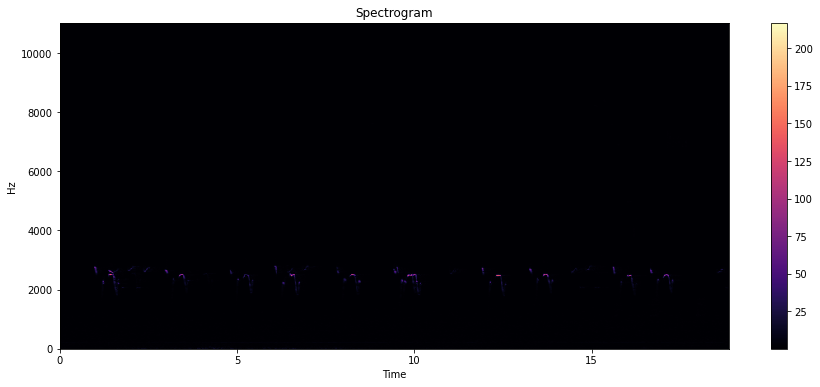

In [13]:
# load the file
hop_length = 512
n_fft = 2048
stft = librosa.stft(data, n_fft=n_fft,  hop_length=hop_length)

# get magnitude
spectrogram = np.abs(stft)

# plot
plt.figure(figsize=(15,6))
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz')
plt.colorbar();
plt.title('Spectrogram');

## Log Spectrogram (decibels)
The log spectrogram converts the magnitude to decibels.  Decibels are on log scale to mimic human hearing.

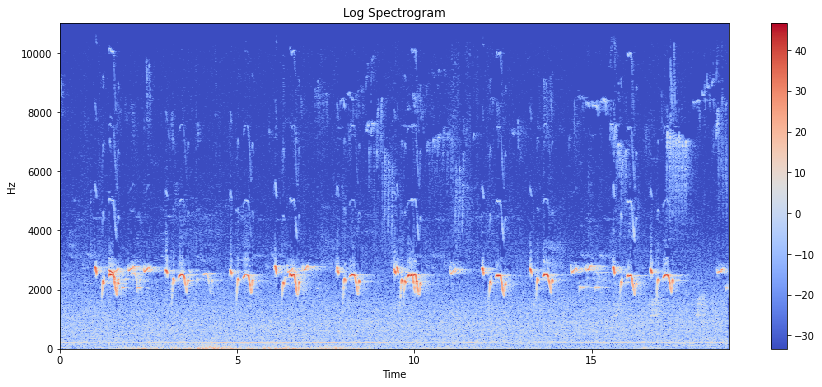

In [14]:
# convert spectrogram to log_spectrogram
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# plot
plt.figure(figsize=(15,6))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz')
plt.colorbar();

plt.title('Log Spectrogram');


## Mel Spectrogram

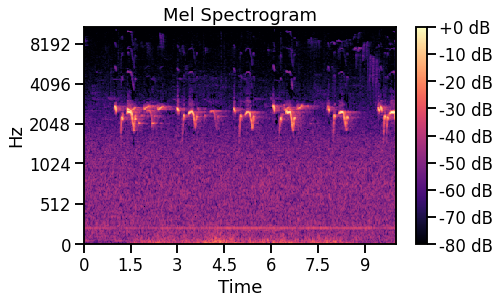

In [16]:
# mel spectrogram plot for presentation

# plot mel spectrogram
n_mels = 256
S = librosa.feature.melspectrogram(data[:220500], 
                                   sr=sr, 
                                   n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
# convert to db
S_DB = librosa.power_to_db(S, ref=np.max)

# plot
with sns.plotting_context("talk", font_scale=1):

    fig = plt.figure(figsize=(7,4))

    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Mel Spectrogram')

    # Make Transparent for presentation
    fig.set_facecolor('None')
    ax.set_facecolor('None')

# Files

In [17]:
# get list of all the mp3 files
audio_files = glob(os.path.join('data/train_audio/*', '*.mp3'), recursive=True)
audio_files[:5]

['data/train_audio/olsfly/XC386256.mp3',
 'data/train_audio/olsfly/XC484154.mp3',
 'data/train_audio/olsfly/XC239498.mp3',
 'data/train_audio/olsfly/XC368006.mp3',
 'data/train_audio/olsfly/XC156193.mp3']

## Get statistics from recordings

In [18]:
# check if we already have a stored version of this data
path = 'dataframes'
fname = os.path.join(path,'audio_files_df.pkl')


if os.path.exists(fname):
    # Load the dataframe if it is saved
    with open(fname, 'rb') as fp:
        audio_files_df = pickle.load(fp)
    print('Loaded dataframe from disk')

else:
    # data holder
    stats = {
        'duration': [],
        'sample_rate': [],
        'bitrate': [],
        'bird_id': [],
        'file_name': []
    }

    # loop through files to extract metrics
    for af in tqdm(audio_files):    
        stats['duration'].append(sox.file_info.duration(af))
        stats['sample_rate'].append(sox.file_info.sample_rate(af))    
        stats['bitrate'].append(sox.file_info.bitrate(af))

        path_split = af.split('/')
        stats['bird_id'].append(path_split[-2])
        stats['file_name'].append(path_split[-1])

    # create the dataframe from stats
    audio_files_df = pd.DataFrame(stats)
    
    # save the dataframe
    os.makedirs(path, exist_ok=True)
    with open(fname, 'wb') as fp:
        pickle.dump(audio_files_df, fp)

Loaded dataframe from disk


In [19]:
# look at df
audio_files_df.head()

,duration,sample_rate,bitrate,bird_id,file_name
0,86.273000,48000.0,320000.0,olsfly,XC386256.mp3
1,13.023000,48000.0,323000.0,olsfly,XC484154.mp3
2,55.129002,44100.0,129000.0,olsfly,XC239498.mp3
3,13.391995,44100.0,130000.0,olsfly,XC368006.mp3
4,60.393991,44100.0,129000.0,olsfly,XC156193.mp3


In [20]:
# descriptive statistics
audio_files_df.describe()

,duration,sample_rate,bitrate
count,21373.000000,21374.000000,2.137300e+04
mean,56.335922,45343.706138,1.727374e+05
std,76.392698,3228.307337,8.485620e+04
min,0.390998,8000.000000,1.920000e+04
25%,15.442993,44100.000000,1.290000e+05
50%,33.203991,44100.000000,1.300000e+05
75%,68.352000,48000.000000,1.940000e+05
max,2283.936000,48000.000000,4.430000e+06


## Duration

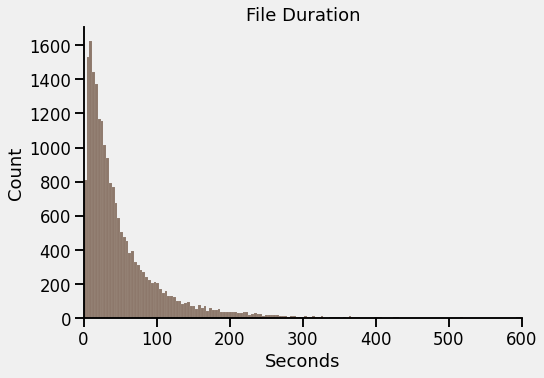

In [21]:
# plot file duration
with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", 
                                                                font_scale=1):
    
    # create fig and plot
    fig = plt.figure(figsize=(7,5))
    ax = sns.histplot(audio_files_df['duration'], color=colors[0])
    
    # xaxis range (crop off outliers)
    plt.xlim([0, 600])
    
    # labels
    plt.title('File Duration')
    plt.xlabel('Seconds')
    
    # formatting    
    plt.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

### Duration Outliers
There are some definte outliers. We need to know if they have an example of the bird song at the beginning of the track and if they don't we should drop them.

In [22]:
audio_files_df[audio_files_df['duration'] > 20]

,duration,sample_rate,bitrate,bird_id,file_name
0,86.273000,48000.0,320000.0,olsfly,XC386256.mp3
2,55.129002,44100.0,129000.0,olsfly,XC239498.mp3
4,60.393991,44100.0,129000.0,olsfly,XC156193.mp3
5,57.338005,44100.0,113000.0,olsfly,XC430786.mp3
6,104.937007,44100.0,128000.0,olsfly,XC249977.mp3
...,...,...,...,...,...
21346,70.355011,44100.0,128000.0,grnher,XC144306.mp3
21348,25.623991,44100.0,193000.0,grnher,XC319278.mp3
21352,25.971000,48000.0,130000.0,grnher,XC173633.mp3
21359,21.390000,48000.0,130000.0,grnher,XC253773.mp3


In [23]:
# what are the longest files?
audio_files_df = audio_files_df.sort_values('duration', ascending=False)
audio_files_df.head()

,duration,sample_rate,bitrate,bird_id,file_name
1064,2283.936000,48000.0,80300.0,comrav,XC246425.mp3
20355,2240.612993,44100.0,320000.0,snobun,XC487556.mp3
20350,2138.572993,44100.0,320000.0,snobun,XC487557.mp3
20904,1285.213000,48000.0,320000.0,stejay,XC503349.mp3
7680,1093.650000,48000.0,320000.0,prawar,XC479026.mp3


## Sample Rate

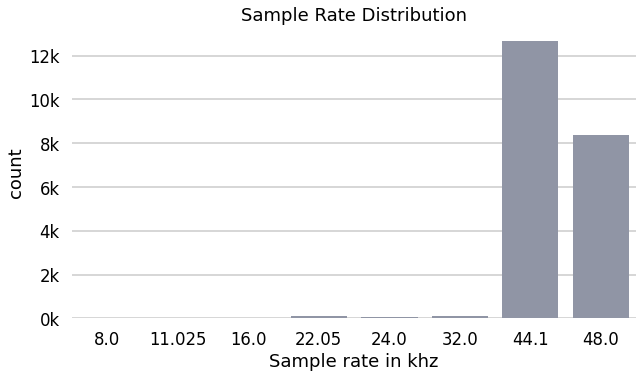

In [27]:
# plot sample rate distribution
with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1):
    
    # create figure and plot
    fig = plt.figure(figsize=(9,5))
    ax = sns.countplot(x = audio_files_df['sample_rate']/1000,
                       color=colors[2])
    
    # formatting
    plt.title('Sample Rate Distribution');
    plt.xlabel('Sample rate in khz')
    plt.box(on=False)
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.yaxis.set_major_formatter(lambda x, pos: str(int(x/1000)) + 'k')

    # make transparent for presentation
    fig.set_facecolor('None')
    ax.set_facecolor('None')